In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
from einops import rearrange
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split

from uni2ts.eval_util.plot import plot_single, plot_next_multi
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule

In [41]:
SIZE = "large"  # model size: choose from {'small', 'base', 'large'}
CTX = 300  # context length: any positive integer
PDT =  68
PSZ = "auto"  # patch size: choose from {"auto", 8, 16, 32, 64, 128}
BSZ = 32  # batch size: any positive integer


# 1. Forecasting with Moirai

Given a time series, Moirai (prediction model) use the context window as input and outputs a prediction window. So, the user need to set the **context_length** and **prediction_length** in advance. 

For time series data, the information contained within a single timestamp is not rich enough. Therefore, we refer to consecutive time points as 'patches', forming the basic units of Moirai input (similar to the concept of word token in Language Models). Moirai provides various ***patch_size*** [8, 16, 32, 64, 128].

Additionally, users need to select the **model size** ('small', 'base', 'large') of Moirai for prediction, along with the **batch_size**, which determines the number of samples that can be inferred in parallel. Since Moirai supports probablistic forecast, users should specify the **num_samples**, indicating the number of times it has to sample the forecasting distribution.

In [117]:
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-{SIZE}"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=8,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)


In [43]:
# prepare a long panads dataframe for the model
def prepare_for_moirai_long_dataframe(df, ctx, bsz,pdt):
    newdata = rearrange(df["target"].to_numpy()[:ctx*bsz], "(b c) -> b c", b=bsz, c=ctx)
    start_dates = df.index[:ctx*bsz:ctx].to_period("D")
    inp = {
        "target": newdata,
        "start": start_dates,
        "feat_static_cat": np.array([0]*bsz)
    }


    # create an array of label data by looping over in batch data and filing the label with the next CTX values
    newlabeldata = np.zeros(shape=(bsz, pdt))
    newstart = np.zeros(bsz, dtype=type(df.index[ctx].to_period(freq="D")))
    for i in range(bsz):
        newlabeldata[i,:] = df["target"].to_numpy()[(i+1)*ctx:(i+1)*ctx+pdt]
        if i < bsz-1:
            newstart[i] = start_dates[i+1] #df.index[i*(CTX+1)].to_period("D")
        else:
            newstart[i] = df.index[ctx*bsz+1].to_period("D")

    # create a sample for the hourly data, using one week data as context window and predicting the next two days.
    label = {
        "target": newlabeldata, 
        "start": newstart,
    }
    
    # Time series values for gluonts with shape (batch, time, variate)
    past_target = rearrange(
        torch.as_tensor(inp["target"], dtype=torch.float32), "b c -> b c ()"
    )
    # 1s if the value is observed, 0s otherwise. Shape: (batch, time, variate)
    past_observed_target = torch.ones_like(past_target, dtype=torch.bool)
    # 1s if the value is padding, 0s otherwise. Shape: (batch, time)
    past_is_pad = torch.zeros_like(past_target, dtype=torch.bool).squeeze(-1)

    return inp,label,past_target,past_observed_target,past_is_pad

In [44]:
# prepare a long panads dataframe for the model
def prepare_for_moirai_wide_dataframe(df, bsz, ctx,pdt):

    # this function will use the most recent data for the context window and predict the next pdt values

    # extract all rows for all columns that start with target_i
    # Filter columns that start with 'target_i'
    filtered_df = df.filter(regex='^target_')

    # Convert the filtered DataFrame to a NumPy array
    numpy_array = filtered_df.to_numpy()
    newdata = numpy_array[-ctx-pdt:-pdt,:].T
    # newdata = rearrange(numpy_array[:ctx,:].T, "(b c) -> b c", b=bsz, c=ctx)
    # make an array of equal start dates for the batch
    start_dates = np.full(bsz,df.index[-ctx-pdt].to_period("D"))
    
    inp = {
        "target": newdata,
        "start": start_dates,
        "feat_static_cat": np.array([-ctx-pdt]*bsz)
    }


    # create an array of label data by looping over in batch data and filing the label with the next CTX values
    newlabeldata = np.zeros(shape=(bsz, pdt))
    newstart = np.full(bsz,df.index[-pdt].to_period("D"))
    newlabeldata = numpy_array[-pdt:,:].T
    # create a sample for the hourly data, using one week data as context window and predicting the next two days.
    label = {
        "target": newlabeldata, 
        "start": newstart,
    }
    
    # Time series values for gluonts with shape (batch, time, variate)
    past_target = rearrange(
        torch.as_tensor(inp["target"], dtype=torch.float32), "b c -> b c ()"
    )
    # 1s if the value is observed, 0s otherwise. Shape: (batch, time, variate)
    past_observed_target = torch.ones_like(past_target, dtype=torch.bool)
    # 1s if the value is padding, 0s otherwise. Shape: (batch, time)
    past_is_pad = torch.zeros_like(past_target, dtype=torch.bool).squeeze(-1)

    return inp,label,past_target,past_observed_target,past_is_pad

In [129]:
# plot the forecasted data
def plot_moirai(inp, label, forecast,field,fname,figsize=(15, 10)):

    # get batch from the input shape (batch, time, variate)
    BSZ = inp["target"].shape[0]
    # get CTX from the input shape (batch, time, variate)
    CTX = inp["target"].shape[1]
    # get PDT from the label shape (batch, time, variate)
    PDT = label["target"].shape[1]

    # calculate the number of subplots based on the batch size and 2 columns
    ncols = 2
    # calculate the number of rows, up to 10 rows
    nrows = min(BSZ//ncols,10)
    bsz2 = ncols*nrows

    # Create subplots
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    for i in range(bsz2):
        ax = axes[i]

        # create a time array for the x-axis
        time_steps = np.arange(0, len(inp["target"][i])+len(label["target"][i]))
        
        # concatenate the input and label data
        crap=np.concatenate([inp["target"][i,:],label["target"][i]])
        #
        # Plot input data
        ax.plot(time_steps,crap, label='Input', color='black')
        
        
        # Plot 0.5 and 0.9 percentiles
        lower_percentile = np.percentile(forecast[i], 5, axis=0)
        upper_percentile = np.percentile(forecast[i], 95, axis=0)
        ax.fill_between(time_steps[CTX:CTX+PDT], lower_percentile, upper_percentile, color='blue', alpha=0.3, label='0.5-0.9 Percentile')


        # # Plot forecasted data
        median_forecast = np.median(forecast[i], axis=0)
        ax.plot(time_steps[CTX:CTX+PDT],median_forecast, label='Forecast (Median)', color='orange',linewidth=2)
        
        # ylim that is based on the data min and max and standard deviation
        ax.set_ylim([min(crap)-np.std(crap),max(crap)+np.std(crap)])


        ax.grid(True)
        
        ax.set_title(f'{field} {i+1}')
        ax.legend()

    # Hide any unused subplots
    for j in range(BSZ, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig(f"./plots/{fname}.png")
    plt.savefig(f"./plots/{fname}.svg")
    plt.show()

    # save the input, label and forecast data into a single data frame
    df_forecast = pd.DataFrame()
    for i in range(BSZ):
        Nlen = len(np.arange(0, len(inp["target"][i])+len(label["target"][i])))
        crap_array = np.full(Nlen, np.nan)
        crap_array[CTX:CTX+PDT] = np.median(forecast[i], axis=0)
        crap_arrayL = np.full(Nlen, np.nan)
        crap_arrayL[CTX:CTX+PDT] = np.percentile(forecast[i], 5, axis=0)
        crap_arrayU = np.full(Nlen, np.nan)
        crap_arrayU[CTX:CTX+PDT] = np.percentile(forecast[i], 95, axis=0)
        df_forecast = pd.concat([df_forecast, pd.DataFrame({
            "time": np.arange(0, len(inp["target"][i])+len(label["target"][i])),
            "input": np.concatenate([inp["target"][i,:],label["target"][i]]),
            "forecast": crap_array,
            "lower_percentile": crap_arrayL,
            "upper_percentile":crap_arrayU ,
            "label": np.concatenate([np.full(CTX, np.nan),label["target"][i]])
        })], axis=0)
    df_forecast.to_csv(f"./plots/{fname}.csv", index=False)


## 1. Earthquake catalogs

     datetime  count
0  2008-01-01    120
1  2008-01-02     89
2  2008-01-03    146
3  2008-01-04    166
4  2008-01-05     94
total length: 3653
time frequency: 1 days 00:00:00


<Axes: xlabel='datetime'>

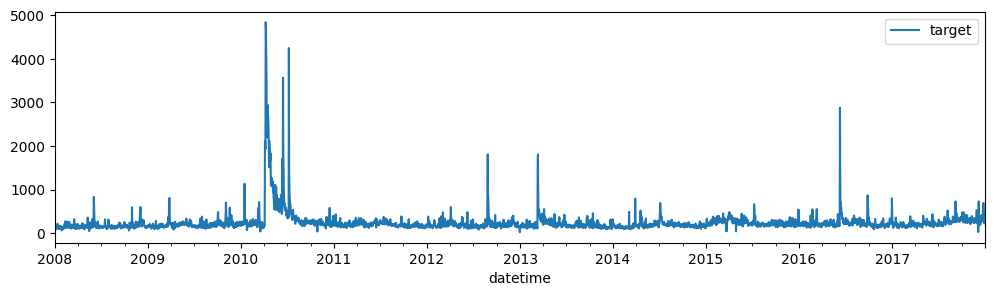

In [46]:
# Load dataframe and plot it
# first we load data/data_qtm_catalog.csv
df = pd.read_csv("../data/data_qtm_catalog.csv")
print(df.head())
# move datetime as index of the dataframe
df["datetime"] = pd.to_datetime(df["datetime"])
# rename count to target
df = df.rename(columns={"count": "target"})
df = df.set_index("datetime")
# df = df[df["item_id"] == "A"].drop(columns=["item_id"])
print(f"total length: {df.shape[0]}")
print(f"time frequency: {df.index.diff()[1]}")
df.plot(figsize=(12, 3))


In [47]:
#how many batches can we have given the CTX size and the length of the dataset
BSZ = (len(df)-PDT)//CTX
print(f"batch size: {BSZ}") 

batch size: 11


In [48]:
# prepare data for moirai
#how many batches can we have given the CTX size and the length of the dataset
BSZ = (len(df)-PDT)//CTX
print(f"batch size: {BSZ}") 
inp,label,past_target,past_observed_target,past_is_pad =  prepare_for_moirai_long_dataframe(df, CTX, BSZ,PDT)


batch size: 11


In [49]:
past_is_pad.shape

torch.Size([11, 300])

In [50]:
# Make prediction
forecast = model(
    past_target=past_target,
    past_observed_target=past_observed_target,
    past_is_pad=past_is_pad,
)
print(forecast.shape,CTX,PDT,BSZ)

torch.Size([11, 100, 68]) 300 68 11


In [51]:
print(
    "median prediction:\n",
    np.round(np.median(forecast[1], axis=1), decimals=4),
)
print("ground truth:\n", label["target"][1])

median prediction:
 [179.2236 191.911  191.9485 176.42   192.0823 177.6921 194.3388 189.6306
 189.6382 179.4292 188.1109 197.6741 180.3492 182.2176 208.1533 184.561
 216.3518 205.9581 172.2442 198.7577 192.6255 204.2151 204.0504 182.9093
 178.6637 177.7064 172.8406 186.1303 180.2353 188.8289 178.028  204.0934
 194.3178 164.6921 199.9154 172.6998 172.1446 185.6933 182.9137 179.7654
 184.4287 203.9497 181.3848 202.3537 170.8807 197.6812 191.0768 184.6485
 190.7362 188.8928 183.1151 185.3028 187.122  178.7808 186.4391 176.9251
 192.5675 194.0393 186.3079 200.188  187.6967 181.6495 167.2172 187.9831
 184.4602 190.6155 194.0714 199.4499 188.4492 185.7569 184.9841 172.9754
 198.9882 186.1107 190.4073 180.7506 187.6169 187.3796 180.2931 188.7558
 187.5288 203.7136 177.111  196.5917 188.2668 185.9719 181.853  203.3921
 179.4175 179.098  176.3854 189.4688 195.4185 189.1084 197.6347 180.2248
 160.2999 192.705  167.1691 202.4543]
ground truth:
 [143. 130. 148. 138. 146. 138. 125. 189. 228. 178. 1

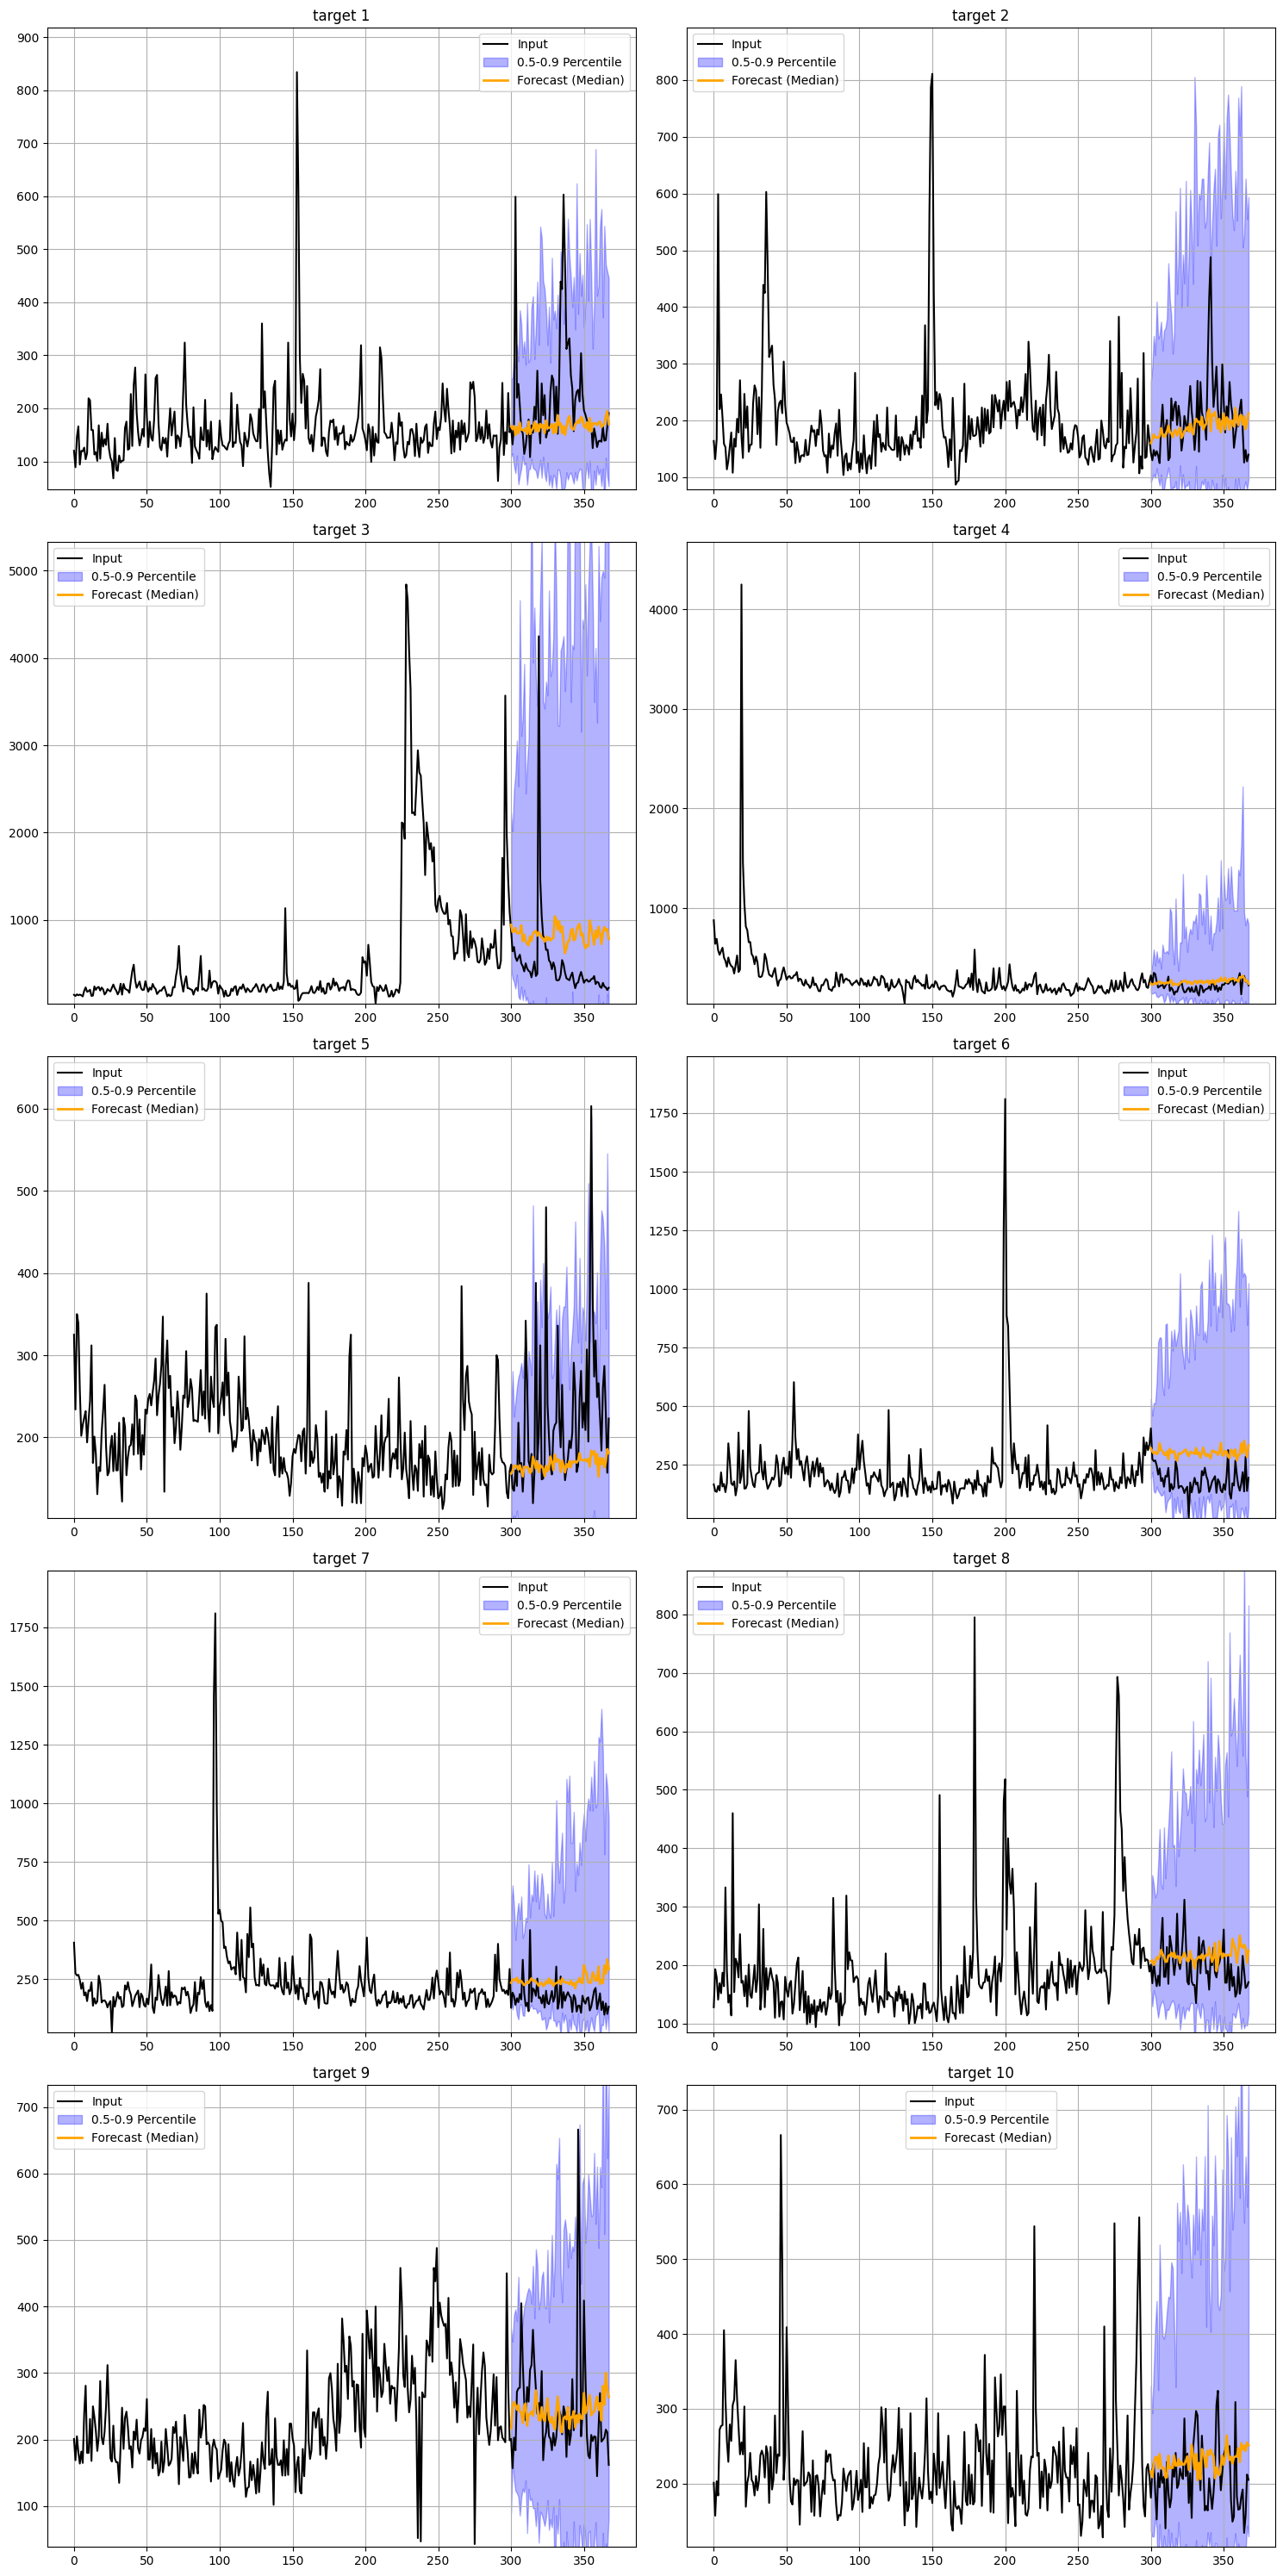

In [52]:
plot_moirai(inp, label, forecast,"target","moirai_forecast")

## 2. Icesheet velocities

Now we test the time series of icesheet velocities in Greenland. This is work done by Brad Lipovsky.

In [53]:

'''
Read the data
'''
df = pd.read_csv('../data/data_ice_jakobshavn.csv',na_values=[-1])


In [54]:
# calculate the time difference between each datetime to set up the dt
# convert the datetime column to datetime object
df["datetime"] = pd.to_datetime(df["Date"])
dt = df["datetime"].diff().dt.total_seconds().fillna(0).mean()
# convert seconds to days
dt = np.ceil(dt / (60 * 60 * 24))
print("sampling rate {} days".format(dt))

sampling rate 8.0 days


In [55]:
# rename all columns to target_1, target_2, etc, except for the datetime and date
df = df.rename(columns={col: f"target_{i}" for i, col in enumerate(df.columns) if col != "datetime" and col != "Date"})
# make new dataframe with the datetime and the target column
# remove Date column
df = df.drop(columns=["Date"])
# set the datetime as the index
df = df.set_index("datetime")
df.head()



target_1   target_2   target_3   target_4   target_5   target_6  \
datetime                                                                       
2015-01-01  2690.5570  2682.3616  2658.6174  2606.9355  2530.3400  2432.4604   
2015-01-13  2714.7678  2694.3774  2657.5322  2604.6094  2541.0916  2492.7390   
2015-01-25  2712.4210  2724.5880  2735.8308  2645.3513  2518.3074  2460.4731   
2015-02-06        NaN        NaN        NaN        NaN  2428.0410  2308.0483   
2015-02-18  2641.4170  2613.6772  2577.1538  2528.2330  2444.6372  2356.7375   

             target_7   target_8   target_9  target_10  ...  target_91  \
datetime                                                ...              
2015-01-01  2337.5603  2238.3130  2131.6187  2016.7839  ...  1909.6104   
2015-01-13  2451.3862  2415.7693  2235.5337  2045.5532  ...  1922.0476   
2015-01-25  2262.7056  2141.2844  2034.8848  1925.2605  ...  1873.9923   
2015-02-06  2250.8723  2212.7468  2080.9092  1901.7308  ...  1938.1514   
2015-02-18  2280.1716  2216.3354  2187.7751  2140.2834  ...  1863.8460   

            target_92  target_93  target_94  target_95  target_96  target_97  \
datetime                                                                       
2015-01-01  1860.1473  1811.2555  1772.2811  1739.5938  1691.1827  1651.6400   
2015-01-13  1866.2997  1801.4703  1747.1519  1679.1748  1619.7880  1580.2765   
2015-01-25  1807.4071  1738.1703  1679.8862  1627.8777  1575.1526  1554.8282   
2015-02-06  1914.6561  1867.8999  1821.8802  1757.2567  1673.6622  1596.8252   
2015-02-18  1803.6461  1748.5105  1696.6669  1643.1813  1591.3317  1547.9862   

            target_98  target_99  target_100  
datetime                                      
2015-01-01  1610.4110  1563.1417   1513.4183  
2015-01-13  1548.2367  1506.4203   1471.4894  
2015-01-25  1534.6147  1520.7195   1515.0082  
2015-02-06  1527.3679  1468.2152   1424.4463  
2015-02-18  1504.9419  1459.6843   1411.1000  

[5 rows x 100 columns]

In this case, we will do batch prediction on the pixels

In [57]:
#format the data for MOIRAI
BSZ = len(df.keys())
print(f"batch size: {BSZ}")
inp,label,past_target,past_observed_target,past_is_pad =  prepare_for_moirai_wide_dataframe(df, BSZ, CTX,PDT)

In [58]:
# Make prediction
ibad=0
try: 
    forecast = model(
        past_target=past_target,
        past_observed_target=past_observed_target,
        past_is_pad=past_is_pad,
    )
    print(forecast.shape,CTX,PDT,BSZ)
except:
    print("error")
    ibad = 1

error


In [59]:
if ibad==0: plot_moirai(inp, label, forecast,"Ice Velocity (m/a)","moirai_ice_forecast")

## 3. GPS time series

In [60]:
# read data from data_gps_P395_relateive_position.csv
fname = "../data/data_gps_P395_relative_position.csv"
df = pd.read_csv(fname)
# convert dacimal year column to floats
df["decimal year"] = df["decimal year"].astype(float)

# the date format is in decimal years, convert it to datetime
# df["datetime"] = pd.to_datetime(df["decimal year"], format="%Y.%j")
# df.head()


# perform a running mean average to smooth the data
for ikey in df.keys()[1:]:
    df[ikey]=df[ikey].rolling(window=20).mean()

df=df.dropna()
df.head()

decimal year  new delta e (m)  new delta n (m)  new delta v (m)
19     2006.1191         0.000501        -0.000668         0.000501
20     2006.1218         0.000554        -0.000639         0.000430
21     2006.1246         0.000612        -0.000548         0.000527
22     2006.1273         0.000644        -0.000513         0.000359
23     2006.1300         0.000653        -0.000306        -0.000209

In [61]:

sta_name = fname.split("/")[-1].split("_")[2]
print(sta_name)

P395


In [62]:
# take the first column "decimal year" and convert it to a datetime by taking the year before the comma, then multuply by 365.25 to get the days
df["datetime"] = pd.to_datetime((df["decimal year"] - 1970) * 365.25, unit='D', origin='1970-01-01')
# move the last to the first position
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df.head()

datetime  decimal year  new delta e (m)  \
19 2006-02-13 12:01:50.159996416     2006.1191         0.000501   
20 2006-02-14 11:41:55.679996544     2006.1218         0.000554   
21 2006-02-15 12:14:36.960003200     2006.1246         0.000612   
22 2006-02-16 11:54:42.480003328     2006.1273         0.000644   
23 2006-02-17 11:34:48.000003456     2006.1300         0.000653   

    new delta n (m)  new delta v (m)  
19        -0.000668         0.000501  
20        -0.000639         0.000430  
21        -0.000548         0.000527  
22        -0.000513         0.000359  
23        -0.000306        -0.000209

In [63]:
# first extract the new delta v(m) column and make a new dataframe
df2 = df[["datetime","new delta v (m)"]]
# put datetime as index
df2 = df2.set_index("datetime")
# rename the column to target
df2 = df2.rename(columns={"new delta v (m)": "target"})

batch size: 22
torch.Size([22, 100, 68]) 300 68 22


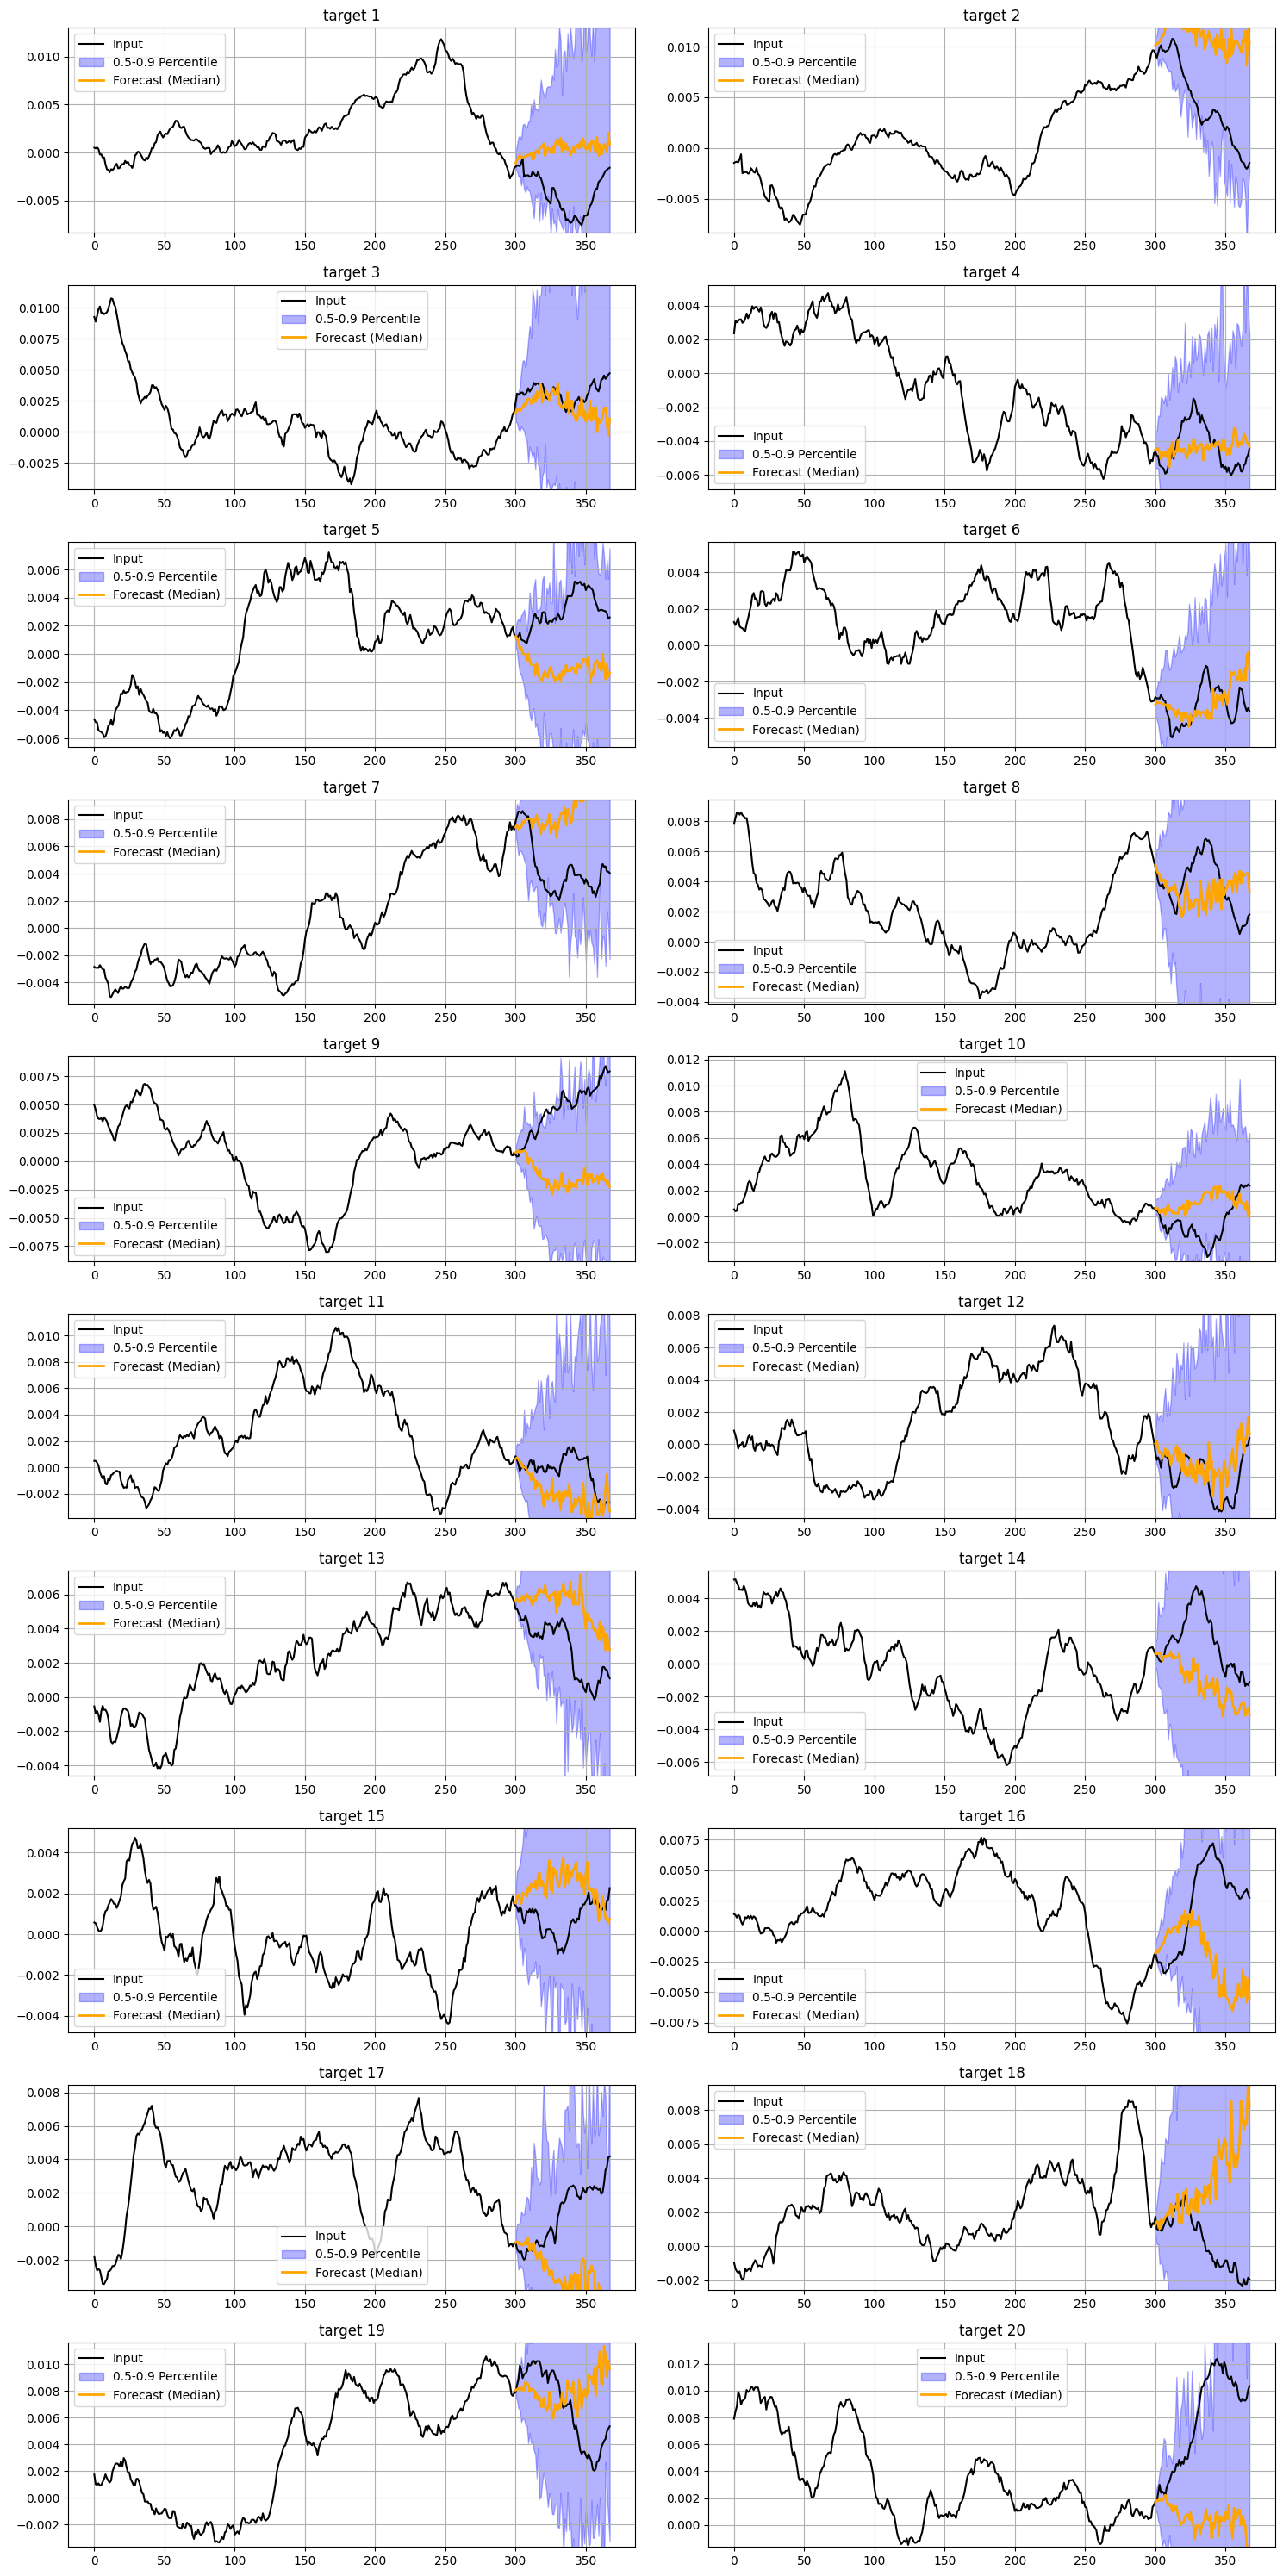

In [64]:
#how many batches can we have given the CTX size and the length of the dataset
BSZ = (len(df2)-PDT)//CTX
print(f"batch size: {BSZ}") 
inp,label,past_target,past_observed_target,past_is_pad =  prepare_for_moirai_long_dataframe(df2, CTX, BSZ,PDT)

# Make prediction
forecast = model(
    past_target=past_target,
    past_observed_target=past_observed_target,
    past_is_pad=past_is_pad,
)
print(forecast.shape,CTX,PDT,BSZ)
plot_moirai(inp, label, forecast,"GPS Vert","moirai_gps_vertical_forecast")


batch size: 22


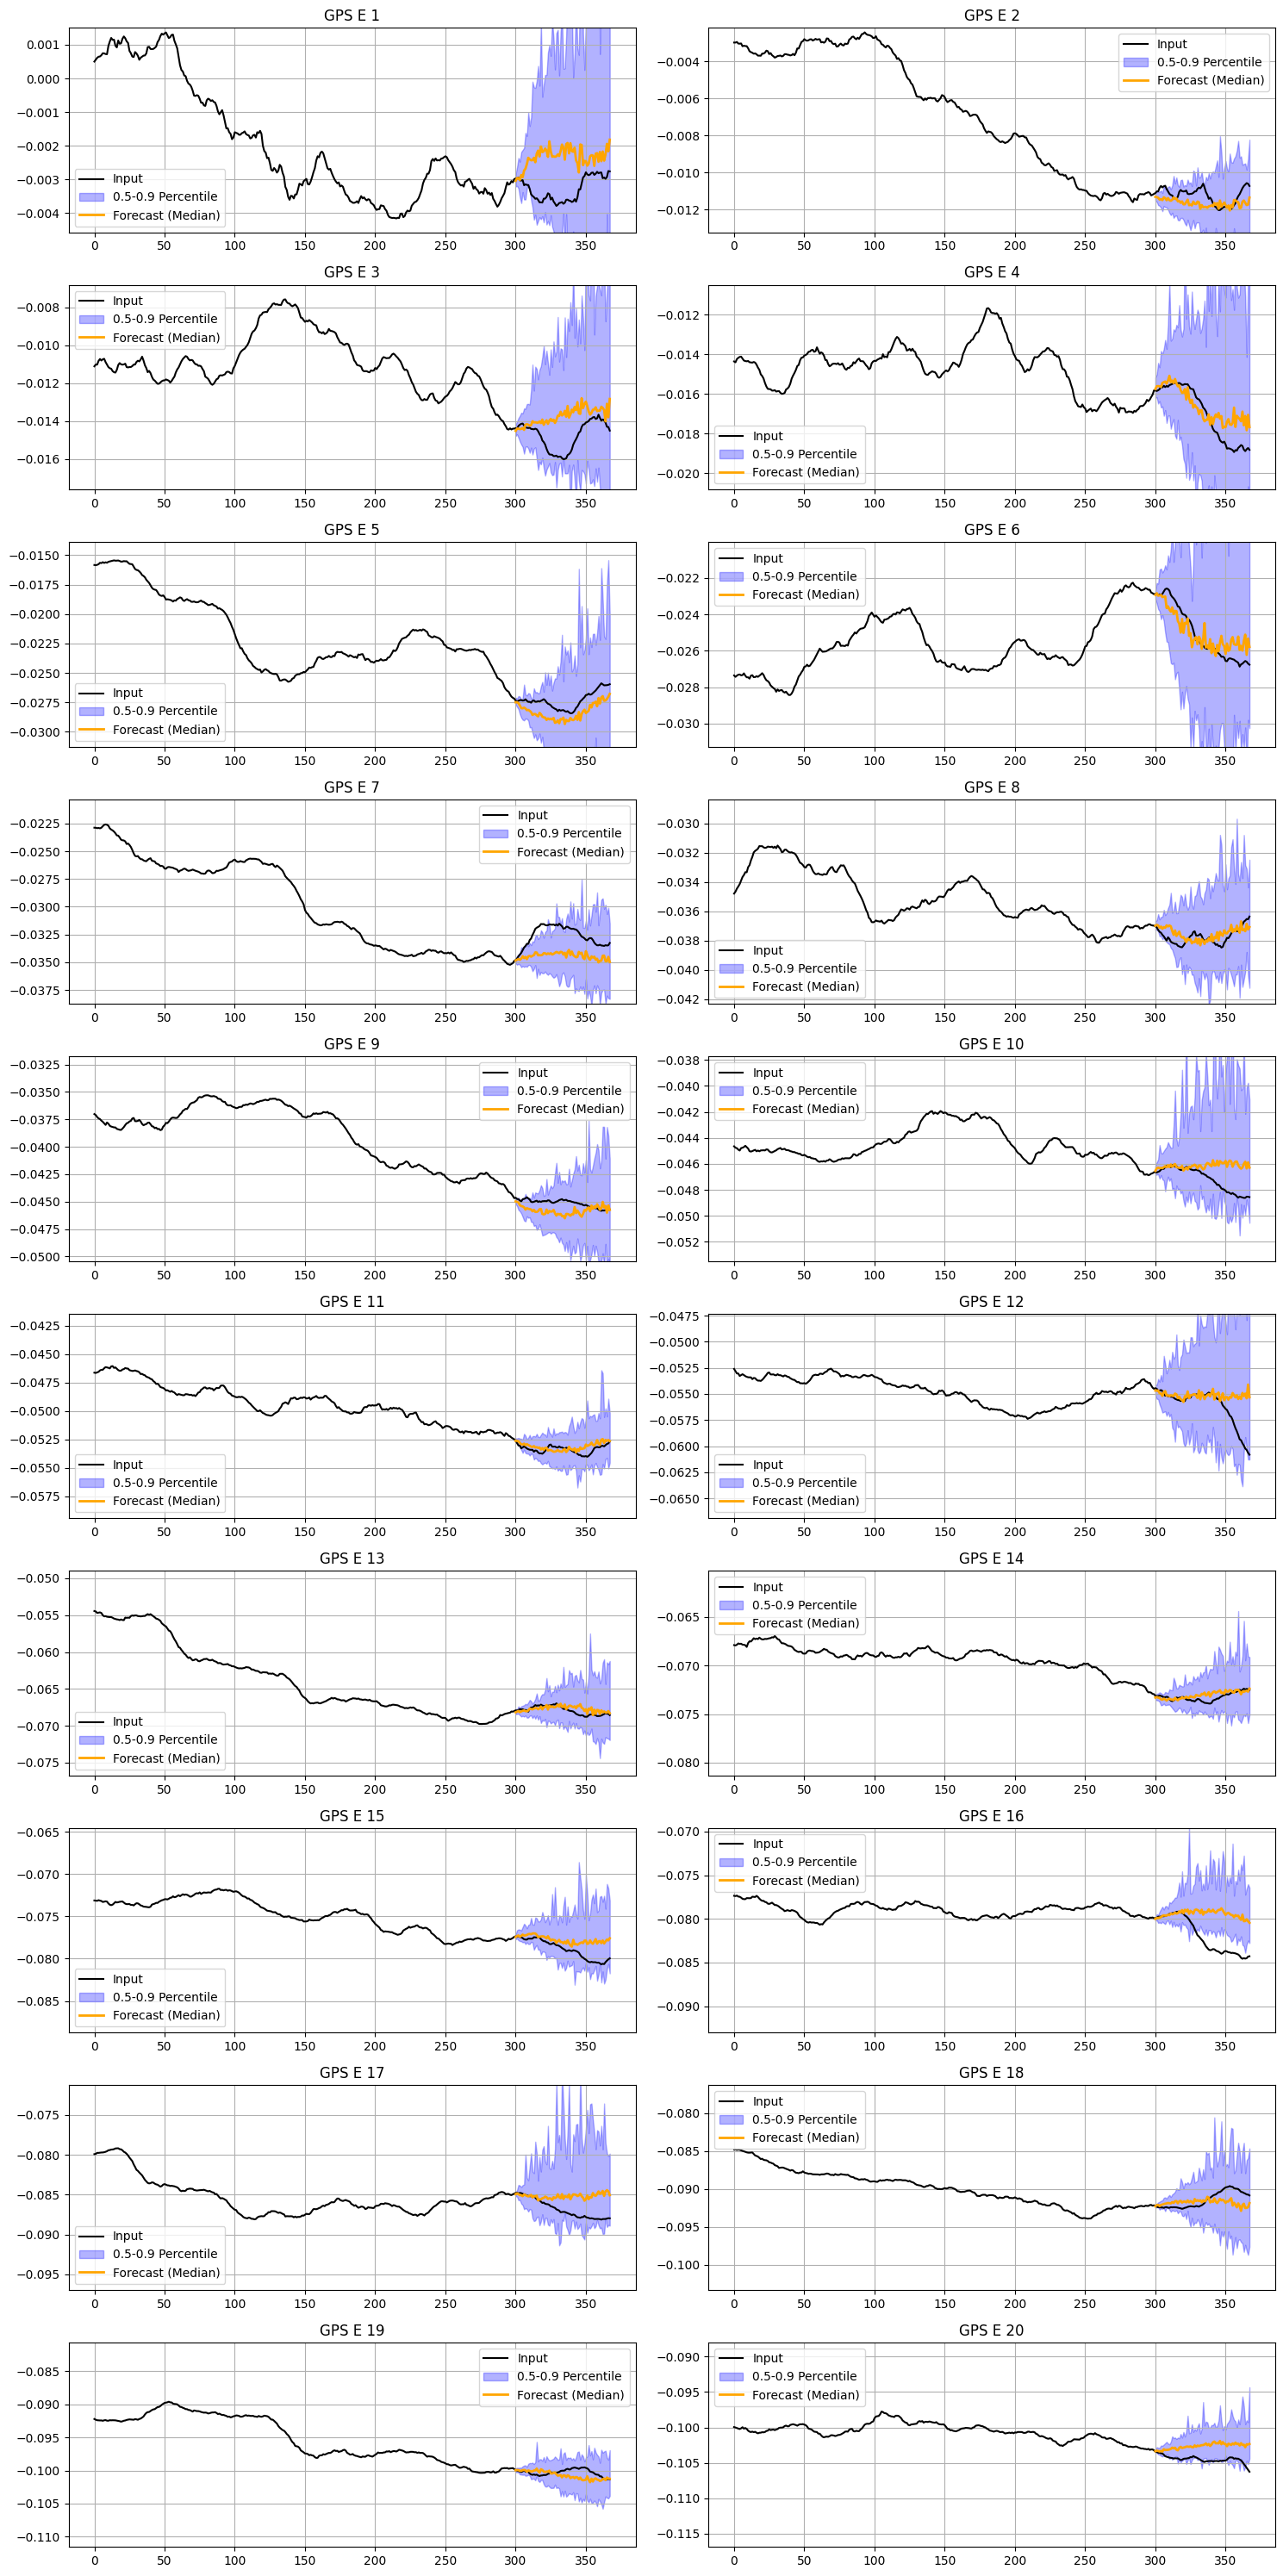

In [79]:
# now do the horizontal data

# first extract the new delta v(m) column and make a new dataframe
df2 = df[["datetime","new delta e (m)"]]
# put datetime as index
df2 = df2.set_index("datetime")
# rename the column to target
df2 = df2.rename(columns={"new delta e (m)": "target"})

#how many batches can we have given the CTX size and the length of the dataset
BSZ = (len(df2)-PDT)//CTX
print(f"batch size: {BSZ}") 
inp,label,past_target,past_observed_target,past_is_pad =  prepare_for_moirai_long_dataframe(df2, CTX, BSZ,PDT)

# Make prediction
forecast = model(
    past_target=past_target,
    past_observed_target=past_observed_target,
    past_is_pad=past_is_pad,
)
plot_moirai(inp, label, forecast,"GPS E","moirai_gps_horizontal_forecast")


## 

## Forecast Subsurface

In [82]:
# read one dv/v file
fname = "../data/DVV_data_withMean/Data_BGU.csv"
df = pd.read_csv(fname)
df.head()
sta_name = fname.split("/")[-1].split("_")[1]

# convert the date into a timestamp
df["datetime"] = pd.to_datetime(df["date"])
# move datetime to the first position
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df.head()

datetime        date      dv    temp  sm_ewt  lp_lake       lake
0 2007-02-03  2007-02-03 -0.1144 -1.9490  0.4645   0.2920  1370.9875
1 2007-02-04  2007-02-04 -0.1211 -1.9249  0.4647   0.2930  1370.9906
2 2007-02-05  2007-02-05 -0.1260 -1.8253  0.4648   0.2939  1370.9936
3 2007-02-06  2007-02-06 -0.1276 -1.5767  0.4649   0.2949  1370.9969
4 2007-02-07  2007-02-07 -0.1357 -1.3691  0.4651   0.2958  1371.0000

In [99]:
# Here we extend the context given that we have 20 years of daily data

CTX = 5*365 # 5 years
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-{SIZE}"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=8,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)


### Soil moisture

batch size: 3


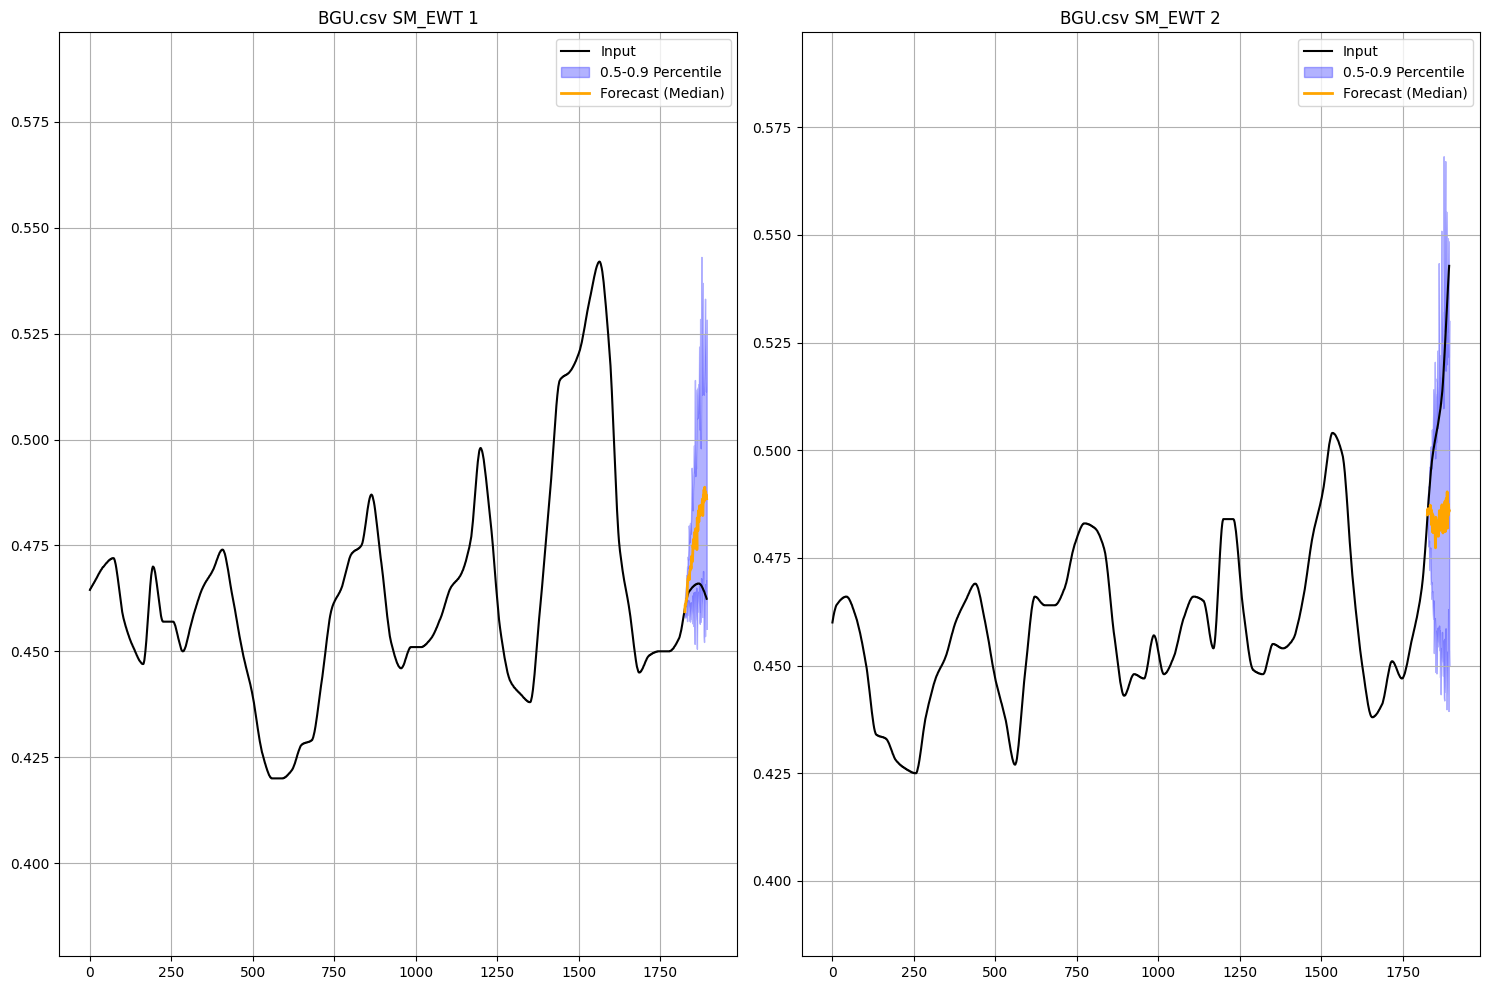

In [100]:
# First predict soil moisture


# first extract the new delta v(m) column and make a new dataframe
df2 = df[["datetime","sm_ewt"]]
# put datetime as index
df2 = df2.set_index("datetime")
# rename the column to target
df2 = df2.rename(columns={"sm_ewt": "target"})

#how many batches can we have given the CTX size and the length of the dataset
BSZ = (len(df2)-PDT)//CTX
print(f"batch size: {BSZ}") 
inp,label,past_target,past_observed_target,past_is_pad =  prepare_for_moirai_long_dataframe(df2, CTX, BSZ,PDT)

# Make prediction
forecast = model(
    past_target=past_target,
    past_observed_target=past_observed_target,
    past_is_pad=past_is_pad,
)
plot_moirai(inp, label, forecast,f"{sta_name} SM_EWT",f'moirai_{sta_name}_sm_ewt_forecast')



### temperature

In [101]:
df

datetime        date      dv     temp  sm_ewt  lp_lake       lake
0    2007-02-03  2007-02-03 -0.1144  -1.9490  0.4645   0.2920  1370.9875
1    2007-02-04  2007-02-04 -0.1211  -1.9249  0.4647   0.2930  1370.9906
2    2007-02-05  2007-02-05 -0.1260  -1.8253  0.4648   0.2939  1370.9936
3    2007-02-06  2007-02-06 -0.1276  -1.5767  0.4649   0.2949  1370.9969
4    2007-02-07  2007-02-07 -0.1357  -1.3691  0.4651   0.2958  1371.0000
...         ...         ...     ...      ...     ...      ...        ...
5670 2022-08-13  2022-08-13  0.3648  25.3004  0.4547  -0.0000  1369.5224
5671 2022-08-14  2022-08-14  0.3689  25.1911  0.4549  -0.0000  1369.5149
5672 2022-08-15  2022-08-15  0.3698  25.0036  0.4550  -0.0000  1369.5071
5673 2022-08-16  2022-08-16  0.3660  24.8606  0.4550  -0.0000  1369.4997
5674 2022-08-17  2022-08-17  0.3634  24.6660  0.4550  -0.0000  1369.4920

[5675 rows x 7 columns]

batch size: 3


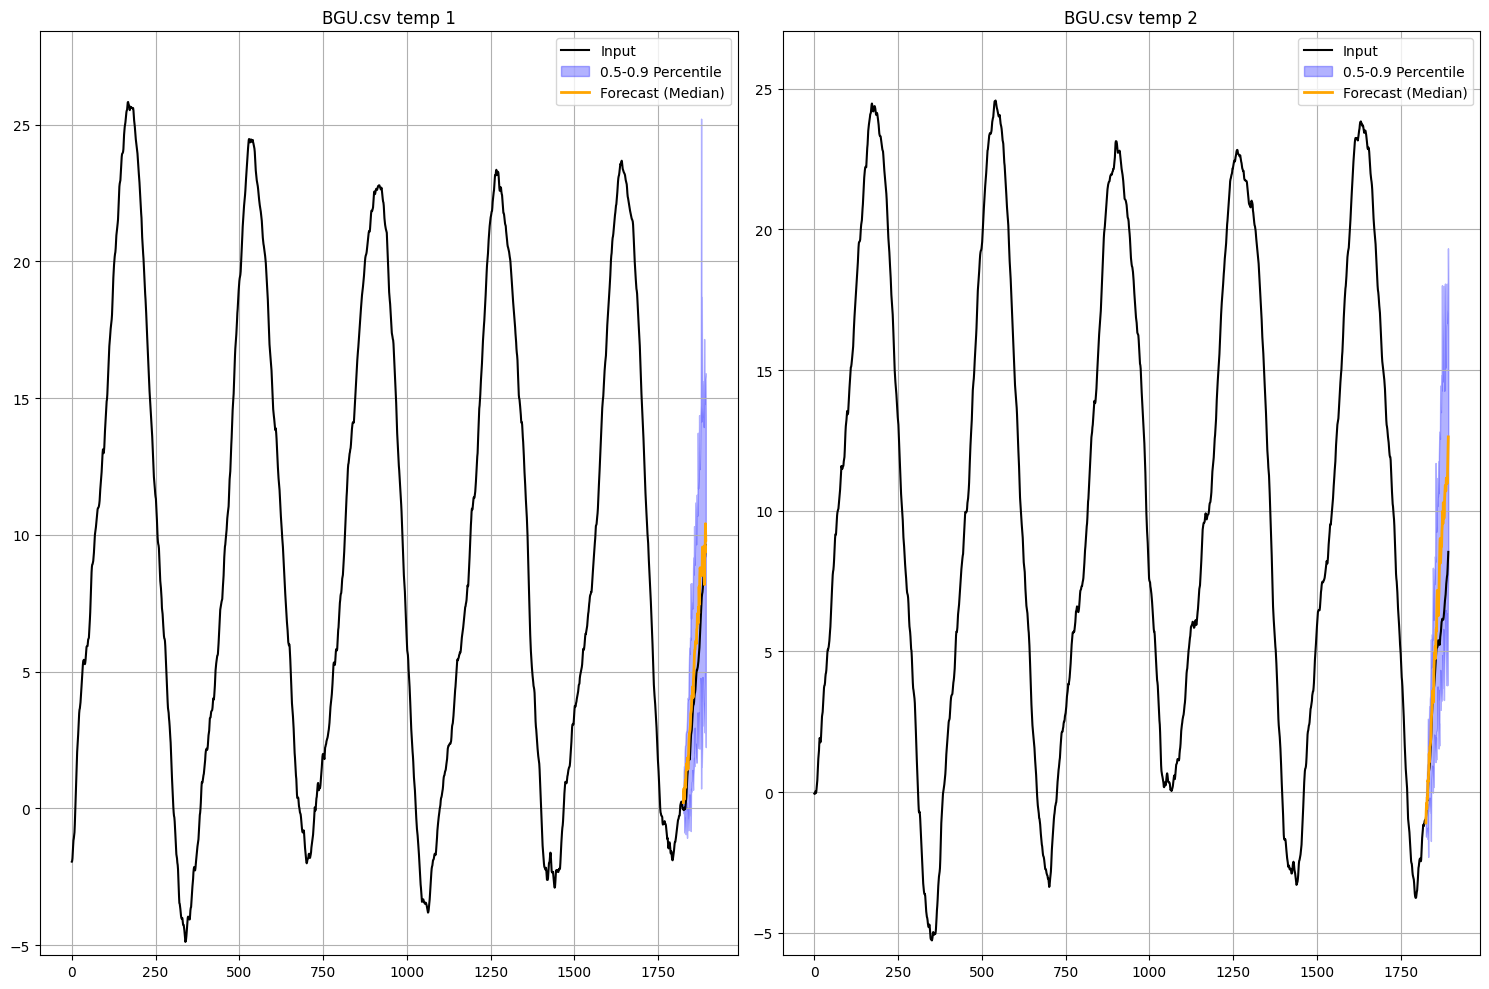

In [102]:
# First predict soil moisture


# first extract the new delta v(m) column and make a new dataframe
df2 = df[["datetime","temp"]]
# put datetime as index
df2 = df2.set_index("datetime")
# rename the column to target
df2 = df2.rename(columns={"temp": "target"})

#how many batches can we have given the CTX size and the length of the dataset
BSZ = (len(df2)-PDT)//CTX
print(f"batch size: {BSZ}") 
inp,label,past_target,past_observed_target,past_is_pad =  prepare_for_moirai_long_dataframe(df2, CTX, BSZ,PDT)

# Make prediction
forecast = model(
    past_target=past_target,
    past_observed_target=past_observed_target,
    past_is_pad=past_is_pad,
)
plot_moirai(inp, label, forecast,f"{sta_name} temp",f'moirai_{sta_name}_temp_forecast')



### dv/v

batch size: 3


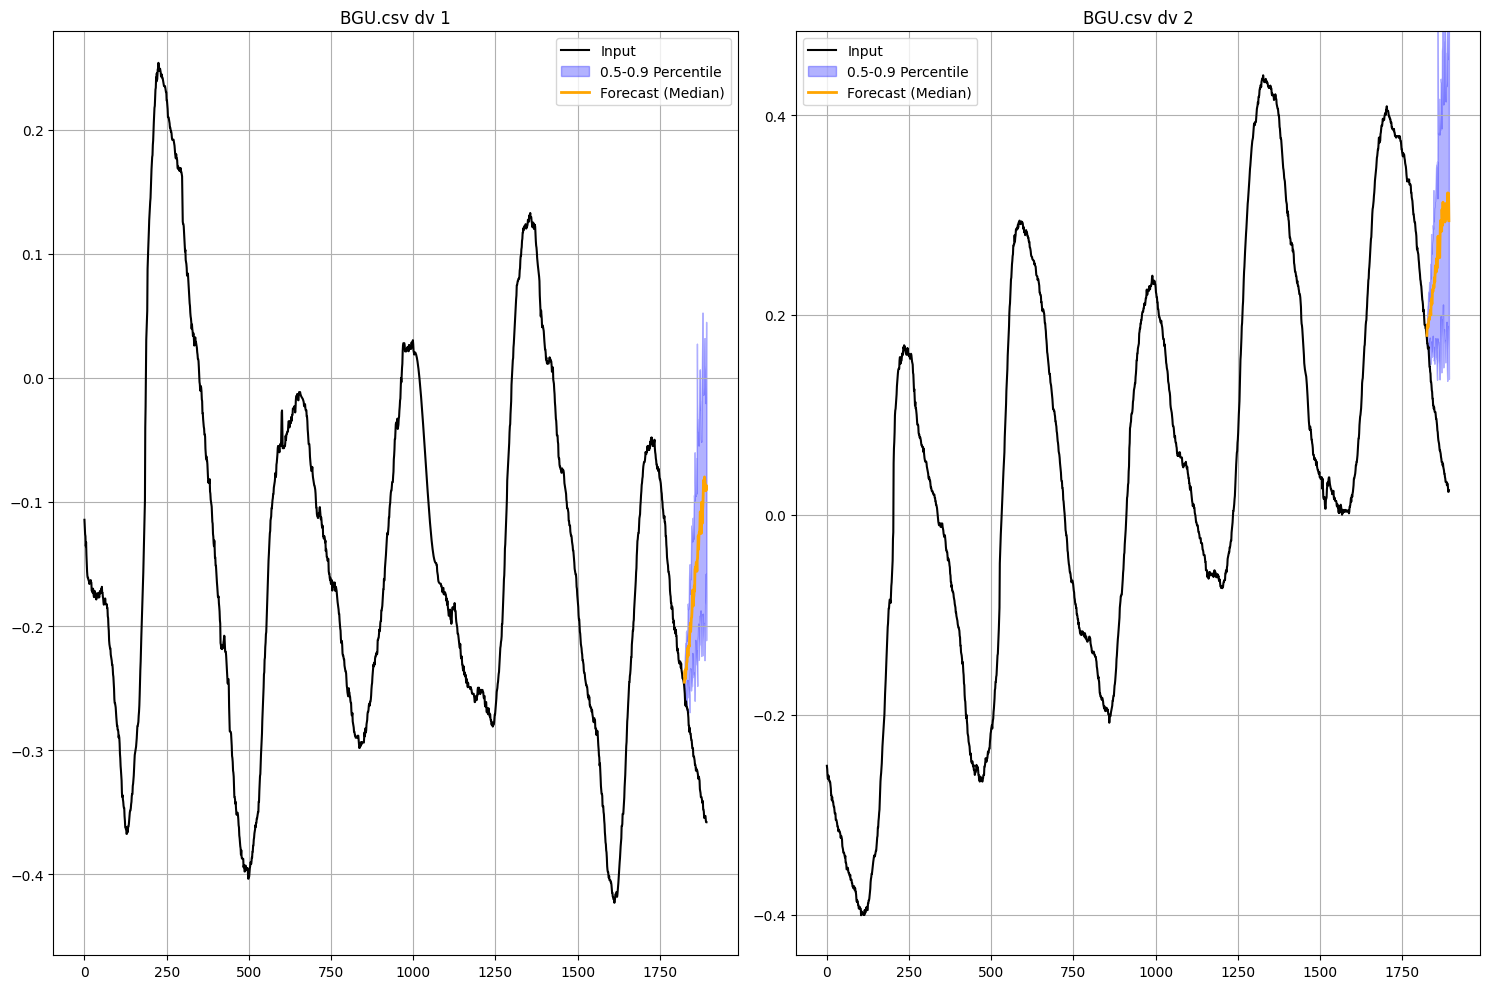

In [103]:
# First predict soil moisture


# first extract the new delta v(m) column and make a new dataframe
df2 = df[["datetime","dv"]]
# put datetime as index
df2 = df2.set_index("datetime")
# rename the column to target
df2 = df2.rename(columns={"dv": "target"})

#how many batches can we have given the CTX size and the length of the dataset
BSZ = (len(df2)-PDT)//CTX
print(f"batch size: {BSZ}") 
inp,label,past_target,past_observed_target,past_is_pad =  prepare_for_moirai_long_dataframe(df2, CTX, BSZ,PDT)

# Make prediction
forecast = model(
    past_target=past_target,
    past_observed_target=past_observed_target,
    past_is_pad=past_is_pad,
)
plot_moirai(inp, label, forecast,f"{sta_name} dv",f'moirai_{sta_name}_dv_forecast')



## Seismic wave data

target_1      target_2      target_3
datetime                                                         
1970-01-01 00:00:00.000  20525.021459 -19224.056196 -47203.488344
1970-01-01 00:00:00.200  -7242.363758   4543.589720  14463.495052
1970-01-01 00:00:00.400  -1562.630597   5935.755557  -9257.204055
1970-01-01 00:00:00.600   -907.924879  -4912.978439   3321.988412
1970-01-01 00:00:00.800   -432.534303   1306.775470  -9014.431029

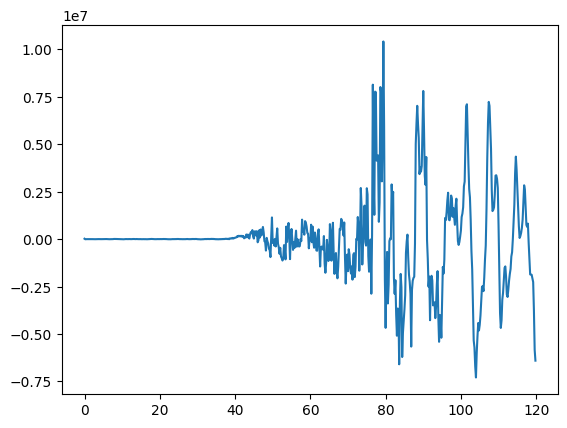

In [113]:
# read CSV file with waveforms in them
df = pd.read_csv("../data/data_waveforms.csv")


# trim data between 100 and 200 rows
df = df.iloc[0:600]
plt.plot(df['time'],df['Z'])
#make a datetime column
df["datetime"] = pd.to_datetime(df["time"], unit='s')

# move datetime to index
df = df.set_index("datetime")
# remove time column
df = df.drop(columns=["time"])
# rename Z to target_i
df = df.rename(columns={"Z": "target_1"})
df = df.rename(columns={"N": "target_2"})
df = df.rename(columns={"E": "target_3"})

df.head()

In [115]:
print(past_target.shape,past_observed_target.shape,past_is_pad.shape)

torch.Size([3, 200, 1]) torch.Size([3, 200, 1]) torch.Size([3, 200])


batch size: 3


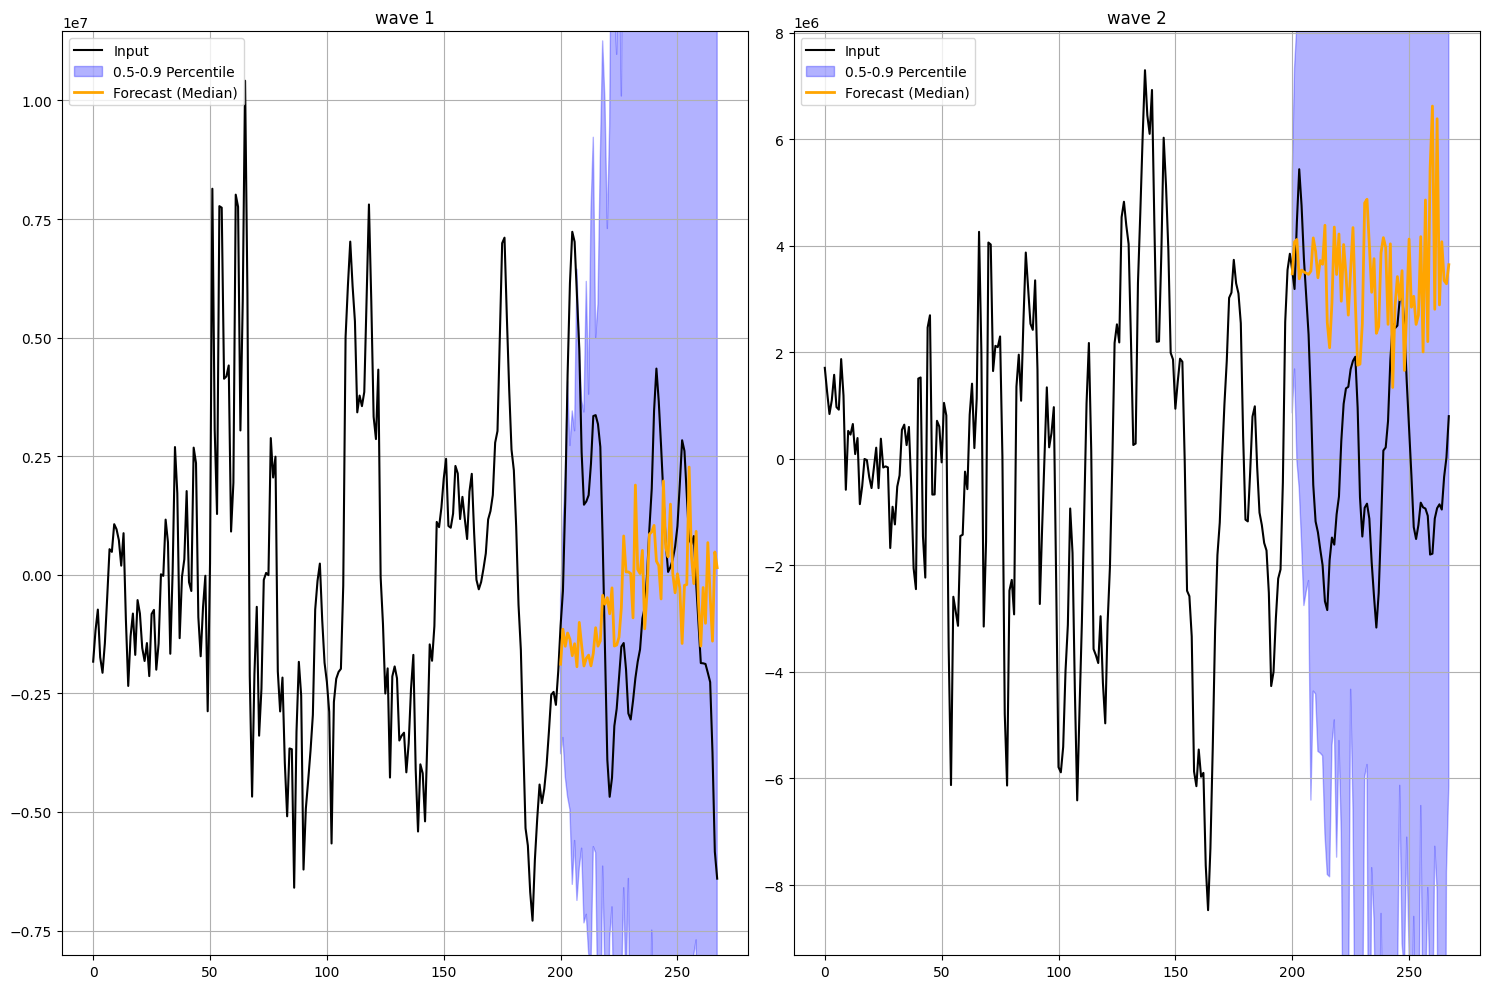

In [118]:
#format the data for MOIRAI
BSZ = len(df.keys())
print(f"batch size: {BSZ}")
CTX=200
PDT=68
inp,label,past_target,past_observed_target,past_is_pad =  prepare_for_moirai_wide_dataframe(df, BSZ, CTX,PDT)
# Make prediction
forecast = model(
    past_target=past_target,
    past_observed_target=past_observed_target,
    past_is_pad=past_is_pad,
)
plot_moirai(inp, label, forecast,"wave",f'moirai_wave_forecast')

## C02

In [120]:
from datetime import datetime, timedelta
fname = "../data/cleaned_data_co2.csv"
df_co2 = pd.read_csv(fname)


# Function to convert decimal year to datetime
def decimal_year_to_datetime(decimal_year):
    year = int(decimal_year)
    remainder = decimal_year - year
    start_of_year = datetime(year, 1, 1)
    days_in_year = (datetime(year + 1, 1, 1) - start_of_year).days
    return start_of_year + timedelta(days=remainder * days_in_year)

# Apply the function to the 'decimale-date' column
df_co2["datetime"] = df_co2["decimale-date"].apply(decimal_year_to_datetime)
# move datetime to index
df_co2 = df_co2.set_index("datetime")


# df_co2["datetime"] = pd.to_datetime((df_co2["decimale-date"] - 1970) * 365.25, origin='1970-01-01', unit='D')
df_co2.head()
# # move datetime to the first position
cols = df_co2.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_co2 = df_co2[cols]

# only keep the monthly-average column and rename it to target
df_co2 = df_co2[["monthly-average"]]
df_co2 = df_co2.rename(columns={"monthly-average": "target"})


df_co2.head()

target
datetime                          
1958-03-15 23:39:07.200002  315.71
1958-04-16 00:15:07.200003  317.45
1958-05-16 00:19:26.399997  317.51
1958-06-16 00:02:52.799999  317.27
1958-07-16 00:07:12.000001  315.87

batch size: 12


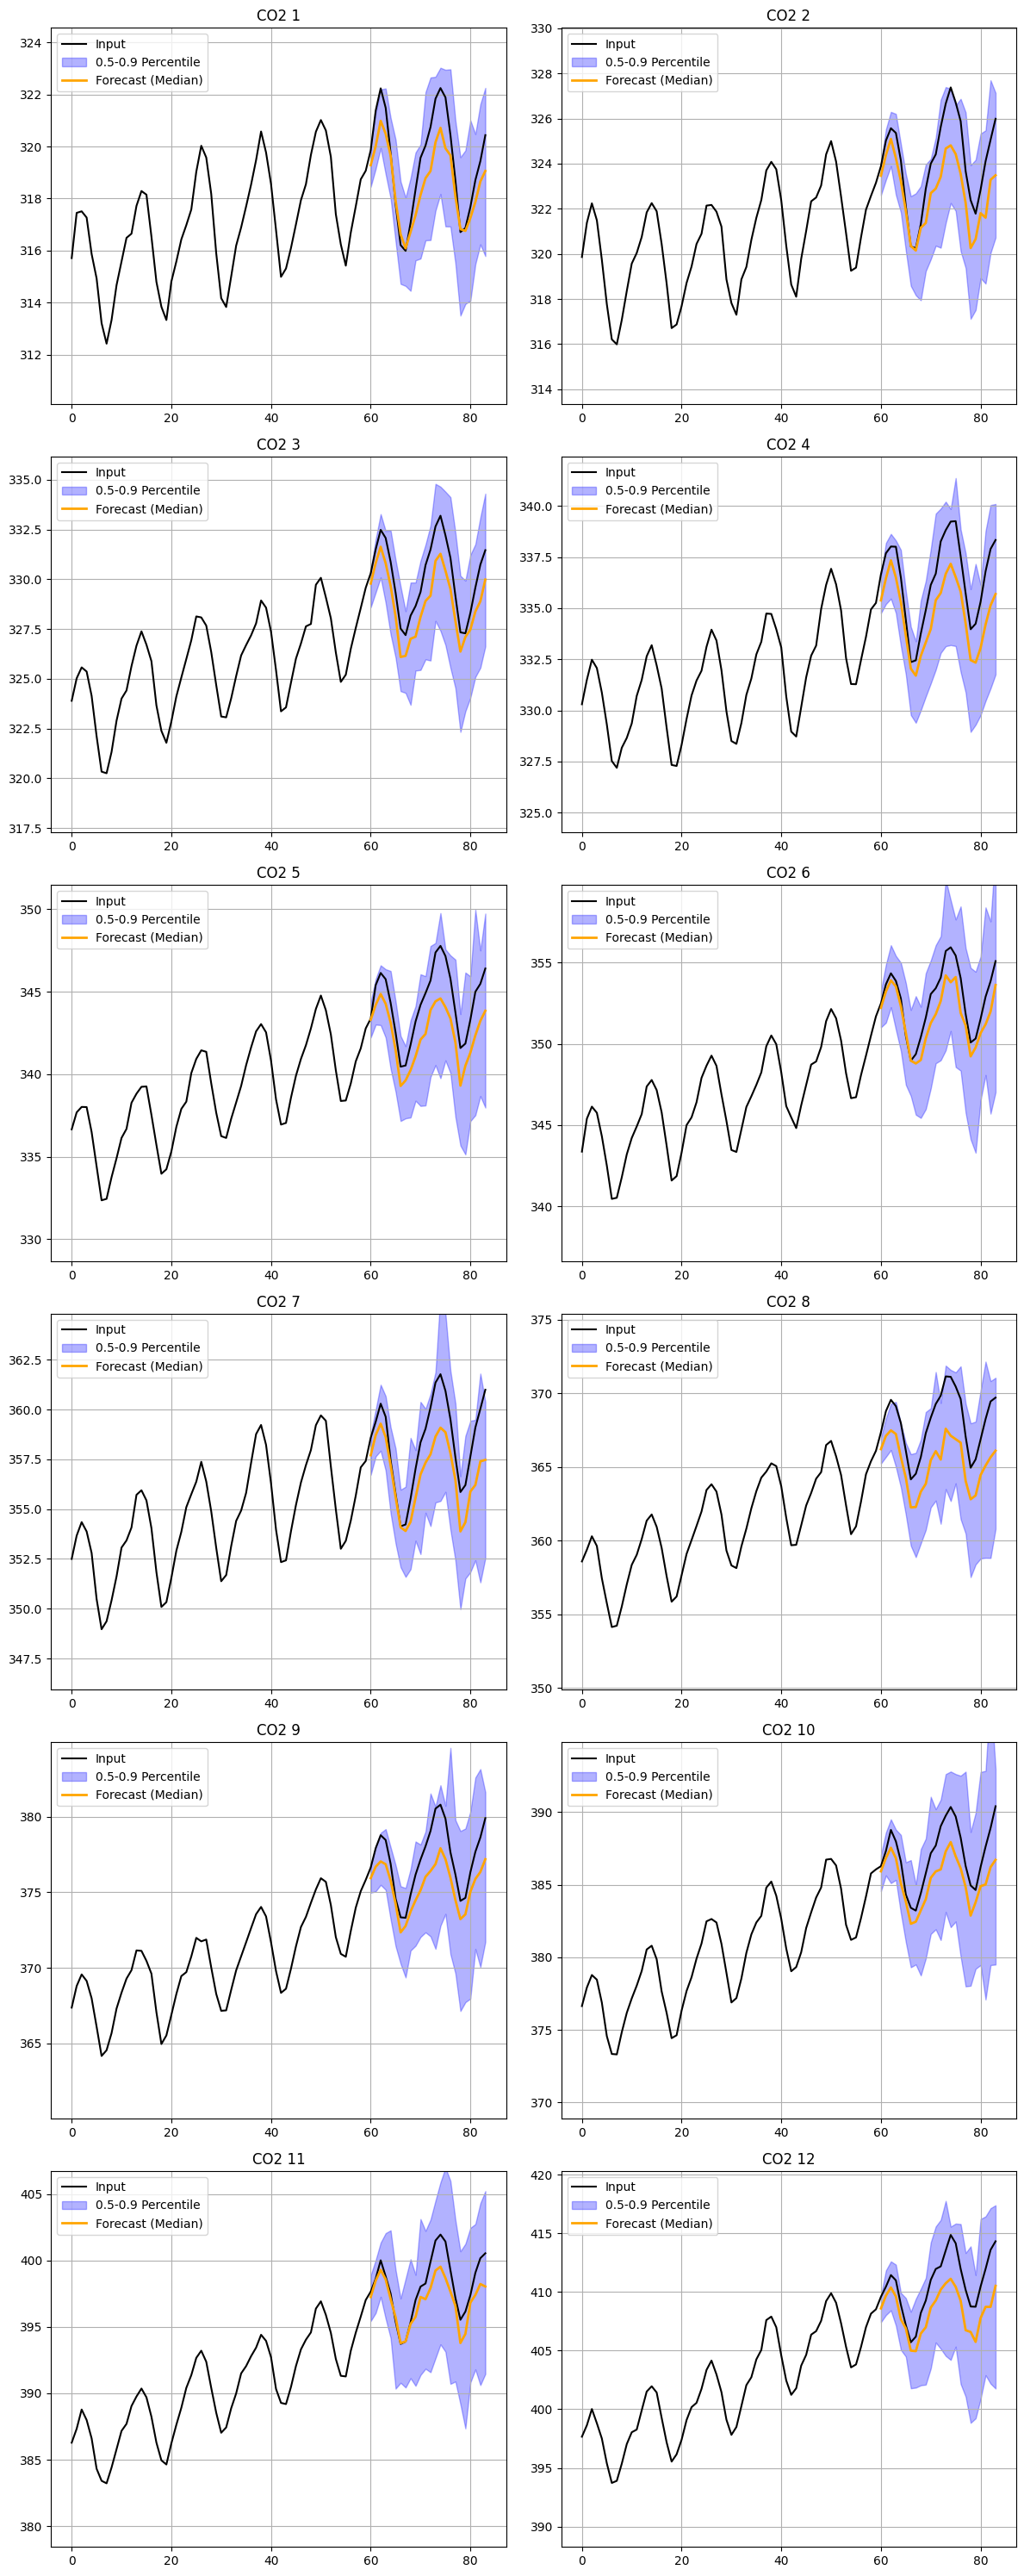

In [130]:
# prepare data for moirai
#how many batches can we have given the CTX size and the length of the dataset
CTX = 12*5
PDT = 12*2
BSZ = (len(df_co2)-PDT)//CTX
print(f"batch size: {BSZ}") 
inp,label,past_target,past_observed_target,past_is_pad =  prepare_for_moirai_long_dataframe(df_co2, CTX, BSZ,PDT)

# make new model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-{SIZE}"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=8,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)

# Make prediction
forecast = model(
    past_target=past_target,
    past_observed_target=past_observed_target,
    past_is_pad=past_is_pad,
)

# plot the forecasted data
plot_moirai(inp, label, forecast,"CO2","moirai_co2_forecast",figsize=(12, 30))


## D018

In [169]:
df_benthic = pd.read_csv("../data/cleaned_lr04.csv")
df_benthic

Time-(ka)  Benthic-d18O-(per-mil)  Standard-error-(per-mil)
0           0.0                    3.23                      0.03
1           1.0                    3.23                      0.04
2           2.0                    3.18                      0.03
3           3.0                    3.29                      0.03
4           4.0                    3.30                      0.03
...         ...                     ...                       ...
2110     5300.0                    2.91                      0.06
2111     5305.0                    2.79                      0.04
2112     5310.0                    2.79                      0.09
2113     5315.0                    2.84                      0.07
2114     5320.0                    2.91                      0.09

[2115 rows x 3 columns]

In [170]:
# for each row, convert the decimal year to a datetime object

# Custom function to handle negative years
def convert_year_to_datetime(year):
    year = -int(year)
    if year == 0:
        return datetime(1, 1, 1)
    elif year < 0:
        return datetime(-year, 1, 1)
    else:
        return datetime(year, 1, 1)

# Apply the custom function to the 'Time-(ka)' column
df_benthic['datetime'] = df_benthic['Time-(ka)'].apply(convert_year_to_datetime)


In [171]:
df_benthic.head()

Time-(ka)  Benthic-d18O-(per-mil)  Standard-error-(per-mil)  \
0        0.0                    3.23                      0.03   
1        1.0                    3.23                      0.04   
2        2.0                    3.18                      0.03   
3        3.0                    3.29                      0.03   
4        4.0                    3.30                      0.03   

              datetime  
0  0001-01-01 00:00:00  
1  0001-01-01 00:00:00  
2  0002-01-01 00:00:00  
3  0003-01-01 00:00:00  
4  0004-01-01 00:00:00

In [172]:
# now reverse the order of the dataframe
df_benthic = df_benthic.iloc[::-1]
# move datetime to index
df_benthic = df_benthic.set_index("datetime")
# remove Time-(ka) column
df_benthic = df_benthic.drop(columns=["Time-(ka)"])
# rename the column to target
df_benthic = df_benthic.rename(columns={"Benthic-d18O-(per-mil)": "target"})
# only keep the target column
df_benthic = df_benthic[["target"]]

In [173]:
df_benthic.head()

target
datetime                   
5320-01-01 00:00:00    2.91
5315-01-01 00:00:00    2.84
5310-01-01 00:00:00    2.79
5305-01-01 00:00:00    2.79
5300-01-01 00:00:00    2.91

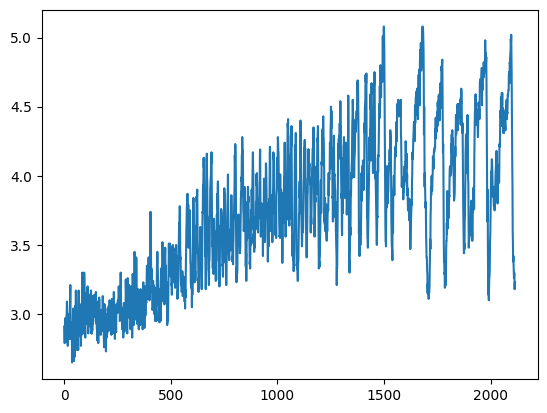

In [174]:
plt.plot(df_benthic["target"].values)
# this is forward in time

In [175]:
# prepare data for moirai
#how many batches can we have given the CTX size and the length of the dataset
CTX = 100
PDT = 64
BSZ = (len(df_benthic)-PDT)//CTX
print(f"batch size: {BSZ}") 
inp,label,past_target,past_observed_target,past_is_pad =  prepare_for_moirai_long_dataframe(df_benthic, CTX, BSZ,PDT)

# make new model
model = MoiraiForecast(
    module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-{SIZE}"),
    prediction_length=PDT,
    context_length=CTX,
    patch_size=8,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)

# Make prediction
forecast = model(
    past_target=past_target,
    past_observed_target=past_observed_target,
    past_is_pad=past_is_pad,
)

# plot the forecasted data
plot_moirai(inp, label, forecast,"d018","moirai_d018_forecast",figsize=(12, 30))


batch size: 20


AttributeError: 'Index' object has no attribute 'to_period'

## 2.2 Loading from a _wide_ DataFrame

In [66]:
# # Load dataframe
# url_wide = (
#     "https://gist.githubusercontent.com/rsnirwan/c8c8654a98350fadd229b00167174ec4"
#     "/raw/a42101c7786d4bc7695228a0f2c8cea41340e18f/ts_wide.csv"
# )
# df = pd.read_csv(url_wide, index_col=0, parse_dates=True)

# df.head()

In [67]:
# # Convert into GluonTS dataset
# ds = PandasDataset(dict(df))

# # Split into train/test set
# train, test_template = split(
#     ds, offset=-TEST
# )  # assign last TEST time steps as test set

# # Construct rolling window evaluation
# test_data = test_template.generate_instances(
#     prediction_length=PDT,  # number of time steps for each prediction
#     windows=TEST // PDT,  # number of windows in rolling window evaluation
#     distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
# )

In [68]:
# # Prepare model
# model = MoiraiForecast(
#     module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
#     prediction_length=PDT,
#     context_length=CTX,
#     patch_size=PSZ,
#     num_samples=100,
#     target_dim=1,
#     feat_dynamic_real_dim=ds.num_feat_dynamic_real,
#     past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
# )

# predictor = model.create_predictor(batch_size=BSZ)
# forecasts = predictor.predict(test_data.input)

# input_it = iter(test_data.input)
# label_it = iter(test_data.label)
# forecast_it = iter(forecasts)

In [69]:
# # Make predictions
# fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
# plot_next_multi(
#     axes,
#     input_it,
#     label_it,
#     forecast_it,
#     context_length=200,
#     intervals=(0.5, 0.9),
#     dim=None,
#     name="pred",
#     show_label=True,
# )

# 2.3 Multivariate Forecasting

In [70]:
# # Load dataframe
# url_wide = (
#     "https://gist.githubusercontent.com/rsnirwan/c8c8654a98350fadd229b00167174ec4"
#     "/raw/a42101c7786d4bc7695228a0f2c8cea41340e18f/ts_wide.csv"
# )
# df = pd.read_csv(url_wide, index_col=0, parse_dates=True)

In [71]:
# # Convert into GluonTS dataset
# ds = PandasDataset(dict(df))

# # Group time series into multivariate dataset
# grouper = MultivariateGrouper(len(ds))
# multivar_ds = grouper(ds)

# # Split into train/test set
# train, test_template = split(
#     multivar_ds, offset=-TEST
# )  # assign last TEST time steps as test set

# # Construct rolling window evaluation
# test_data = test_template.generate_instances(
#     prediction_length=PDT,  # number of time steps for each prediction
#     windows=TEST // PDT,  # number of windows in rolling window evaluation
#     distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
# )

In [72]:
# # Prepare model
# model = MoiraiForecast(
#     module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
#     prediction_length=PDT,
#     context_length=CTX,
#     patch_size=PSZ,
#     num_samples=100,
#     target_dim=len(ds),
#     feat_dynamic_real_dim=ds.num_feat_dynamic_real,
#     past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
# )

# predictor = model.create_predictor(batch_size=BSZ)
# forecasts = predictor.predict(test_data.input)

# input_it = iter(test_data.input)
# label_it = iter(test_data.label)
# forecast_it = iter(forecasts)

In [73]:
# # Make predictions
# inp = next(input_it)
# label = next(label_it)
# forecast = next(forecast_it)

In [74]:
# # Visualize different dimensions
# fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
# for i, ax in enumerate(axes.flatten()):
#     plot_single(
#         inp,
#         label,
#         forecast,
#         context_length=200,
#         intervals=(0.5, 0.9),
#         dim=i,
#         ax=ax,
#         name="pred",
#         show_label=True,
#     )

## 2.4 Include dynamic features

<img src="img/extra_feature.png" alt="Drawing" style="width: 800px;"/>

Moirai supports adding additional covariates. Specifically, it could include past dynamic real features, and dynamic real feature that include features in the prediction window.

In [75]:
# # Load dataframe
# url = (
#     "https://gist.githubusercontent.com/rsnirwan/a8b424085c9f44ef2598da74ce43e7a3"
#     "/raw/b6fdef21fe1f654787fa0493846c546b7f9c4df2/ts_long.csv"
# )
# df = pd.read_csv(url, index_col=0, parse_dates=True)
# T = df.shape[0]
# df["dynamic_real_1"] = np.random.normal(size=T)
# df["past_dynamic_real_2"] = np.random.normal(size=T)

In [76]:
# ds = PandasDataset.from_long_dataframe(
#     df,
#     item_id="item_id",
#     past_feat_dynamic_real=["past_dynamic_real_2"],
#     feat_dynamic_real=["dynamic_real_1"],
# )

# # Split into train/test set
# train, test_template = split(
#     ds, offset=-TEST
# )  # assign last TEST time steps as test set

# # Construct rolling window evaluation
# test_data = test_template.generate_instances(
#     prediction_length=PDT,  # number of time steps for each prediction
#     windows=TEST // PDT,  # number of windows in rolling window evaluation
#     distance=PDT,  # number of time steps between each window - distance=PDT for non-overlapping windows
# )

In [77]:
# # Prepare model
# model = MoiraiForecast(
#     module=MoiraiModule.from_pretrained(f"Salesforce/moirai-1.0-R-small"),
#     prediction_length=PDT,
#     context_length=CTX,
#     patch_size=PSZ,
#     num_samples=100,
#     target_dim=1,
#     feat_dynamic_real_dim=ds.num_feat_dynamic_real,
#     past_feat_dynamic_real_dim=ds.num_past_feat_dynamic_real,
# )

# predictor = model.create_predictor(batch_size=BSZ)
# forecasts = predictor.predict(test_data.input)

# input_it = iter(test_data.input)
# label_it = iter(test_data.label)
# forecast_it = iter(forecasts)

In [78]:
# # Make predictions
# fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))
# plot_next_multi(
#     axes,
#     input_it,
#     label_it,
#     forecast_it,
#     context_length=200,
#     intervals=(0.5, 0.9),
#     dim=None,
#     name="pred",
#     show_label=True,
# )